# Question Answering with Transformers

In [15]:
# Colab Cell 1: install dependencies
!pip install transformers torch --quiet


## 1. Basic Pipeline Setup

In [16]:
# Colab Cell 2: basic QA pipeline
from transformers import pipeline

# 1) initialize the pipeline
qa = pipeline("question-answering")

# 2) supply your context & question
context = (
    "Charles Babbage was an English polymath. "
    "He originated the concept of a programmable computer, "
    "and is sometimes referred to as the 'father of the computer.'"
)
question = "Who is known as the father of the computer?"

# 3) run and print
res = qa(question=question, context=context)


No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [17]:
print(res)

{'score': 0.9982137084007263, 'start': 0, 'end': 15, 'answer': 'Charles Babbage'}


## 2. Use a Custom Pretrained Model

In [18]:
# Colab Cell: Custom QA with deepset/roberta-base-squad2
from transformers import pipeline

# initialize QA pipeline with custom model & tokenizer
qa_roberta = pipeline(
    "question-answering",
    model="deepset/roberta-base-squad2",
    tokenizer="deepset/roberta-base-squad2"
)

# same context & question as before
context = (
    "Charles Babbage was an English polymath. "
    "He originated the concept of a programmable computer, "
    "and is sometimes referred to as the 'father of the computer.'"
)
question = "Who is known as the father of the computer?"

# run and display
result = qa_roberta(question=question, context=context)


Device set to use cpu


In [19]:
print(result)

{'score': 0.980118453502655, 'start': 0, 'end': 15, 'answer': 'Charles Babbage'}


## 3. Test on Your Own Example

In [20]:
from transformers import pipeline

# initialize a QA pipeline (you can omit model/tokenizer to use the default)
qa = pipeline("question-answering")

# your custom 2–3 sentence context
context = (
    "The Amazon Rainforest spans across nine countries in South America. "
    "It is home to an enormous diversity of wildlife and is often called the 'lungs of the planet' "
    "because it produces around 20% of the world's oxygen."
)

# two different questions you want to ask
questions = [
    "What nickname is given to the Amazon Rainforest?",
    "How much of the world's oxygen does it produce?"
]

# run and print results
for q in questions:
    out = qa(question=q, context=context)
    print(f"Q: {q}")
    print(f"A: {out['answer']}  (score: {out['score']:.2f})\n")


No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Q: What nickname is given to the Amazon Rainforest?
A: lungs of the planet  (score: 0.40)

Q: How much of the world's oxygen does it produce?
A: 20%  (score: 0.68)



# Digit-Class Controlled Image Generation with Conditional GAN

In [7]:
# Colab Cell 1 — install dependencies
!pip install torch torchvision matplotlib --quiet


In [8]:
# Colab Cell 2 — imports & hyperparameters
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lr         = 2e-4
latent_dim = 100
num_epochs = 30
img_size   = 28


In [9]:
# Colab Cell 3 — model definitions

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + 10, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_size*img_size),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        # labels: batch of ints [0..9]
        one_hot = torch.zeros(labels.size(0), 10, device=device)
        one_hot.scatter_(1, labels.unsqueeze(1), 1)
        x = torch.cat([noise, one_hot], dim=1)
        img = self.model(x)
        return img.view(-1, 1, img_size, img_size)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size*img_size + 10, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img, labels):
        one_hot = torch.zeros(labels.size(0), 10, device=device)
        one_hot.scatter_(1, labels.unsqueeze(1), 1)
        x = torch.cat([img.view(img.size(0), -1), one_hot], dim=1)
        return self.model(x)


In [21]:
# Colab Cell 4 — data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # → [-1,1]
])
mnist = datasets.MNIST(root=".", train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=batch_size, shuffle=True, drop_last=True)


In [11]:
# Colab Cell 5 — training loop
G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))

for epoch in range(1, num_epochs+1):
    g_loss_running = 0
    d_loss_running = 0
    for real_imgs, labels in loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        bs = real_imgs.size(0)

        # 1) Train Discriminator
        noise = torch.randn(bs, latent_dim, device=device)
        fake_labels = torch.randint(0, 10, (bs,), device=device)
        fake_imgs = G(noise, fake_labels).detach()

        real_loss = criterion(D(real_imgs, labels), torch.ones(bs,1,device=device))
        fake_loss = criterion(D(fake_imgs, fake_labels), torch.zeros(bs,1,device=device))
        d_loss = (real_loss + fake_loss) / 2

        opt_D.zero_grad(); d_loss.backward(); opt_D.step()

        # 2) Train Generator
        noise2 = torch.randn(bs, latent_dim, device=device)
        gen_labels = torch.randint(0, 10, (bs,), device=device)
        gen_imgs   = G(noise2, gen_labels)
        g_loss     = criterion(D(gen_imgs, gen_labels), torch.ones(bs,1,device=device))

        opt_G.zero_grad(); g_loss.backward(); opt_G.step()

        g_loss_running += g_loss.item()
        d_loss_running += d_loss.item()

    print(f"Epoch {epoch:2d}/{num_epochs}  D_loss: {d_loss_running/len(loader):.3f}  G_loss: {g_loss_running/len(loader):.3f}")


Epoch  1/30  D_loss: 0.533  G_loss: 1.253
Epoch  2/30  D_loss: 0.383  G_loss: 2.697
Epoch  3/30  D_loss: 0.357  G_loss: 2.918
Epoch  4/30  D_loss: 0.269  G_loss: 3.335
Epoch  5/30  D_loss: 0.340  G_loss: 3.716
Epoch  6/30  D_loss: 0.256  G_loss: 3.619
Epoch  7/30  D_loss: 0.253  G_loss: 3.539
Epoch  8/30  D_loss: 0.237  G_loss: 4.076
Epoch  9/30  D_loss: 0.302  G_loss: 3.770
Epoch 10/30  D_loss: 0.260  G_loss: 3.852
Epoch 11/30  D_loss: 0.280  G_loss: 4.118
Epoch 12/30  D_loss: 0.249  G_loss: 4.053
Epoch 13/30  D_loss: 0.215  G_loss: 4.271
Epoch 14/30  D_loss: 0.188  G_loss: 4.316
Epoch 15/30  D_loss: 0.168  G_loss: 4.651
Epoch 16/30  D_loss: 0.231  G_loss: 4.807
Epoch 17/30  D_loss: 0.201  G_loss: 5.158
Epoch 18/30  D_loss: 0.230  G_loss: 4.681
Epoch 19/30  D_loss: 0.204  G_loss: 4.417
Epoch 20/30  D_loss: 0.187  G_loss: 4.744
Epoch 21/30  D_loss: 0.173  G_loss: 4.804
Epoch 22/30  D_loss: 0.156  G_loss: 4.742
Epoch 23/30  D_loss: 0.183  G_loss: 4.686
Epoch 24/30  D_loss: 0.196  G_loss

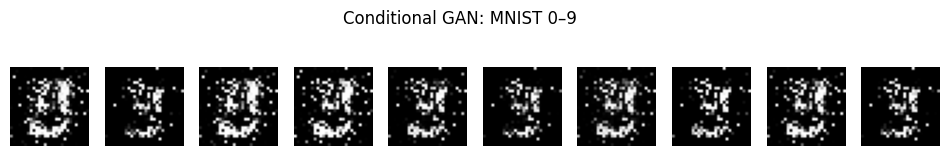

In [14]:
# Colab Cell 6 — generate one row of digits 0–9
G.eval()
with torch.no_grad():
    fixed_noise  = torch.randn(10, latent_dim, device=device)
    fixed_labels = torch.arange(0,10, device=device)
    gen_images   = G(fixed_noise, fixed_labels).cpu()

# plot
fig, axes = plt.subplots(1, 10, figsize=(12,2))
for img, ax in zip(gen_images, axes):
    ax.imshow(img.squeeze(), cmap="gray", vmin=-1, vmax=1)
    ax.axis("off")
plt.suptitle("Conditional GAN: MNIST 0–9")
plt.show()
